In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2016-01-01',
    'to': '2018-12-31',
    'sub_categories': ['HANDICAP_DE_CATEGORIE']
})

loading data 56f9215434abbfe1a00ccd3c6acfe12c from cache
preparing model data
training ridge_0.1
mea: 49.91375840440604
training ridge_1.0
mea: 37.32498490685329
training ridge_10.0
mea: 8.697073775110665
training svr
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
mea: 13.865880773776917
training knn_10
mea: 5.136868327402135
training knn_20
mea: 5.046192170818506
training knn_30
mea: 4.94708316857783
training knn_40
mea: 4.955006919731119
training knn_100
mea: 4.9673100039541325
training mlp_10
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converg

In [4]:
program.dataset.save()
print(program.dataset.hash)
program.model.save()
print(program.model.hash)

56f9215434abbfe1a00ccd3c6acfe12c
8948b3ec9f8d1a9f09e4610a770ae0f9


In [5]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

379 races from 2016-01-05 17:41:00 to 2018-11-19 17:44:00


In [6]:
import pandas as pd
from cataclop.ml import preprocessing

for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


ridge_0.1
race_count_mean                             4.481644
handicap_weight                             3.648748
placed_earnings_mean                        3.359255
placed_earnings_std                         3.347501
placed_3_count_std                          2.912929
placed_2_count_std                          2.874062
race_count                                  1.872129
odds_0                                      1.766817
victory_earnings_amin                       1.459252
placed_3_count_amin                         1.437087
placed_2_count                              1.067537
victory_count_std                           1.041734
odds_2                                      0.994451
odds_5                                      0.897985
placed_earnings                             0.895389
placed_3_count_r                            0.895031
prev_year_earnings                          0.827088
prev_year_earnings_amax                     0.447253
hist_5_pos                          

rf_200
victory_earnings                            0.086544
victory_earnings_r                          0.078211
placed_2_count_r                            0.055853
placed_earnings_r                           0.049907
placed_3_count_r                            0.041334
placed_earnings                             0.036166
hist_1_pos                                  0.032842
handicap_weight_r                           0.031889
placed_2_count_std                          0.031435
race_count_r                                0.028315
victory_count_r                             0.025642
hist_2_pos                                  0.024908
odds_0                                      0.024703
handicap_weight_std                         0.016524
prev_year_earnings_r                        0.015952
prev_year_earnings_amax                     0.015890
hist_6_pos                                  0.014988
handicap_weight_mean                        0.014681
prev_year_earnings_mean                

In [7]:
df = program.df

races = df.groupby('race_id')
for (id, race) in races:
    for model in program.model.models:
        df.loc[race.index, 'pred_{}_std'.format(model['name'])] = race['pred_{}_1'.format(model['name'])].std()
        df.loc[race.index, 'pred_{}_min'.format(model['name'])] = race['pred_{}_1'.format(model['name'])].min()
        df.loc[race.index, 'pred_{}_max'.format(model['name'])] = race['pred_{}_1'.format(model['name'])].max()

In [8]:
stacked_features = ['declared_player_count', 'final_odds_ref'] + ['odds_{:d}'.format(i) for i in range(10)]

stacked_features = stacked_features + ['pred_{}_1'.format(model['name']) for model in program.model.models]
stacked_features = stacked_features + ['pred_{}_std'.format(model['name']) for model in program.model.models]
stacked_features = stacked_features + ['pred_{}_min'.format(model['name']) for model in program.model.models]
stacked_features = stacked_features + ['pred_{}_max'.format(model['name']) for model in program.model.models]

stacked_features



['declared_player_count',
 'final_odds_ref',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'pred_ridge_0.1_1',
 'pred_ridge_1.0_1',
 'pred_ridge_10.0_1',
 'pred_svr_1',
 'pred_knn_10_1',
 'pred_knn_20_1',
 'pred_knn_30_1',
 'pred_knn_40_1',
 'pred_knn_100_1',
 'pred_mlp_10_1',
 'pred_mlp_20_1',
 'pred_mlp_30_1',
 'pred_mlp_40_1',
 'pred_mlp_100_1',
 'pred_gbr_10_1',
 'pred_gbr_20_1',
 'pred_gbr_30_1',
 'pred_gbr_40_1',
 'pred_gbr_100_1',
 'pred_gbr_200_1',
 'pred_rf_10_1',
 'pred_rf_20_1',
 'pred_rf_30_1',
 'pred_rf_40_1',
 'pred_rf_100_1',
 'pred_rf_200_1',
 'pred_ridge_0.1_std',
 'pred_ridge_1.0_std',
 'pred_ridge_10.0_std',
 'pred_svr_std',
 'pred_knn_10_std',
 'pred_knn_20_std',
 'pred_knn_30_std',
 'pred_knn_40_std',
 'pred_knn_100_std',
 'pred_mlp_10_std',
 'pred_mlp_20_std',
 'pred_mlp_30_std',
 'pred_mlp_40_std',
 'pred_mlp_100_std',
 'pred_gbr_10_std',
 'pred_gbr_20_std',
 'pred_gbr_30_std',
 'pred_gbr_40_std',
 

In [9]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, MinMaxScaler, RobustScaler


df['pred_stacked_1'] = 0

from sklearn.model_selection import KFold, GroupKFold

groups = df['race_id'].values

group_kfold = GroupKFold(n_splits=program.model.params['kfolds'])

splits = list(group_kfold.split(df.values, df['position'].values, groups))

for train_index, test_index in splits:
    
    X_train = df[stacked_features].iloc[train_index].copy()
    
    idx = (df.iloc[train_index]['final_odds_ref'] < 20)
    X_train = X_train[ idx ]
    y_train = df['target'].iloc[train_index][ idx ]
    
    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target'].iloc[test_index]
    
    X_train = X_train.values
    X_test = X_test.values
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y_train / y_train.max()
    y_test = y_test / y_train.max()
    
    #estimator = MLPRegressor(activation='logistic', hidden_layer_sizes=(100,), random_state=program.model.params['seed'])
    estimator = RandomForestRegressor(n_estimators=10)
    #estimator = linear_model.Ridge(alpha=.5)
    
    estimator.fit(X_train, y_train.values)
    
    p = estimator.predict(X_test)
    
    idx = df.iloc[test_index].index
    df.loc[idx, 'pred_stacked_1'] = p
    
    

In [10]:
import pandas as pd
from cataclop.ml import preprocessing

if hasattr(estimator, 'feature_importances_'):
    fi = pd.Series(estimator.feature_importances_, index=stacked_features)
    print(fi.sort_values(ascending=False)[0:100])
    
if hasattr(estimator, 'coef_'):
    fi = pd.Series(estimator.coef_, index=stacked_features)
    print(fi.sort_values(ascending=False)[0:100])

final_odds_ref           0.058325
pred_rf_20_min           0.054621
pred_knn_10_1            0.053213
pred_gbr_200_1           0.045941
pred_svr_1               0.044545
pred_ridge_10.0_1        0.040688
pred_ridge_1.0_1         0.032838
pred_knn_100_1           0.032351
pred_mlp_10_1            0.032157
pred_knn_30_1            0.029090
pred_mlp_100_1           0.024663
pred_rf_20_1             0.023136
pred_mlp_40_1            0.022677
pred_knn_20_1            0.020866
pred_rf_40_1             0.020442
pred_rf_30_1             0.019759
pred_rf_10_1             0.019131
pred_ridge_0.1_1         0.018652
pred_knn_40_1            0.017958
pred_rf_200_1            0.017828
pred_gbr_20_max          0.015884
pred_gbr_10_1            0.015774
pred_gbr_100_1           0.011733
pred_gbr_20_1            0.011441
pred_gbr_40_1            0.011359
pred_mlp_40_max          0.010956
pred_svr_min             0.010688
pred_knn_10_min          0.010416
pred_rf_100_1            0.009502
pred_rf_100_ma

In [11]:
from cataclop.ml import exploration

exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked_1', 'pred_knn_10_1', 'pred_rf_10_1', 'pred_rf_100_1']).sort_values(by='position')

position  declared_player_count           sub_category  num  \
race_id                                                                    
2699    330       1.0                     11  HANDICAP_DE_CATEGORIE    5   
        329       2.0                     11  HANDICAP_DE_CATEGORIE    4   
        326       3.0                     11  HANDICAP_DE_CATEGORIE    1   
        331       4.0                     11  HANDICAP_DE_CATEGORIE    6   
        335       5.0                     11  HANDICAP_DE_CATEGORIE   10   
        334       6.0                     11  HANDICAP_DE_CATEGORIE    9   
        327       7.0                     11  HANDICAP_DE_CATEGORIE    2   
        328       8.0                     11  HANDICAP_DE_CATEGORIE    3   
        336       9.0                     11  HANDICAP_DE_CATEGORIE   11   
        332      10.0                     11  HANDICAP_DE_CATEGORIE    7   
        333      11.0                     11  HANDICAP_DE_CATEGORIE    8   

             final_odds  final_odds_ref  pred_stacked_1  pred_knn_10_1  \
race_id                                                                  
2699    330        25.8            15.1        0.021151           3.34   
        329         3.5             3.6        0.008709           3.03   
        326         5.0             4.4        0.014774           4.22   
        331        15.5            17.2        0.027683           3.82   
        335        11.5            23.9        0.032037          10.21   
        334        16.6            11.9        0.051322           4.13   
        327         7.5             5.5        0.026283           5.08   
        328        10.9            17.6        0.021151           5.39   
        336        12.3            25.5        0.018040           2.43   
        332        24.1             9.6        0.033281           6.06   
        333        10.4            23.0        0.031882           7.25   

             pred_rf_10_1  pred_rf_100_1  
race_id                                   
2699    330          6.34          4.646  
        329          3.86          3.419  
        326          2.13          3.937  
        331          6.28          5.760  
        335          6.72          6.505  
        334          1.40          4.391  
        327          1.61          2.930  
        328          5.27          5.259  
        336          9.83          8.068  
        332          3.53          5.644  
        333          8.41          7.431

In [17]:
program.bet(N=1, max_odds=20, break_on_bet=True, break_on_odds=True, targets=['pred_stacked_1'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
bets = program.bets
bets['profit'].describe()

count    5537.000000
mean        0.186852
std         5.191146
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        63.300000
Name: profit, dtype: float64

In [13]:
bets = bets.reset_index(drop=True)

---
PLAT	+1034.60	+5537.00	+5537.00
---
pred_mlp_40_1: 	 -94.10 	 +237 	 -0.40
pred_mlp_100_1: 	 -64.10 	 +186 	 -0.34
pred_knn_30_1: 	 -20.50 	 +225 	 -0.09
pred_knn_100_1: 	 -63.50 	 +223 	 -0.28
pred_knn_10_1: 	 -20.80 	 +221 	 -0.09
pred_knn_40_1: 	 -54.00 	 +220 	 -0.25
pred_mlp_10_1: 	 +57.90 	 +143 	 +0.40
pred_knn_20_1: 	 +19.40 	 +212 	 +0.09
pred_gbr_10_1: 	 +64.70 	 +210 	 +0.31
pred_mlp_30_1: 	 +4.50 	 +150 	 +0.03
pred_mlp_20_1: 	 +5.90 	 +81 	 +0.07
pred_gbr_20_1: 	 +64.60 	 +197 	 +0.33
pred_stacked_1: 	 -7.60 	 +198 	 -0.04
pred_rf_10_1: 	 +55.60 	 +193 	 +0.29
pred_rf_20_1: 	 +35.80 	 +193 	 +0.19
pred_gbr_40_1: 	 +81.30 	 +190 	 +0.43
pred_rf_100_1: 	 +26.10 	 +188 	 +0.14
pred_gbr_100_1: 	 +83.70 	 +189 	 +0.44
pred_rf_30_1: 	 +18.60 	 +187 	 +0.10
pred_gbr_30_1: 	 +84.90 	 +187 	 +0.45
pred_svr_1: 	 +144.50 	 +181 	 +0.80
pred_rf_40_1: 	 +22.60 	 +183 	 +0.12
pred_gbr_200_1: 	 +130.80 	 +183 	 +0.71
pred_ridge_0.1_1: 	 +104.60 	 +179 	 +0.58
pred_ridge_1.0_1: 	 +128

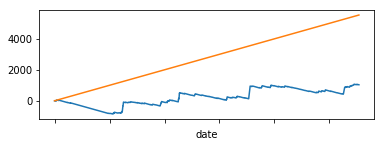

In [18]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#bb = bets.groupby('id').filter(lambda r: r['num'].nunique() == 7 ).copy()
bb = bets.copy()
#bb = bets[(bets['target'].str.contains('^pred_ridge_'))  ].groupby('id').filter(lambda r: r['num'].nunique() >= 1 ).copy()
#bb = bets[(bets['target'].str.contains('^pred_rf_')) | (bets['target'].str.contains('^pred_rf_'))  ].groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets.groupby('id').filter(lambda r: (r['target'] == 'pred_mlp_1').sum() == 0 and (r['target'] == 'pred_knn_10_1').sum() == 1  )

def f(r):
    n1 = r[(r['target'] == 'pred_mlp_40_1')]['num']
    n2 = r[(r['target'] == 'pred_mlp_30_1')]['num']
    
    if not len(n1) and len(n2):
        return True
    if not len(n2) and len(n1):
        return True
    
    if n1.max() != n2.max():
        return True
    
    return False

def f2(r):
    return r[r['target'] == 'pred_rf_']['pred'].max() > 0 and r[r['target'] == 'pred_rf_']['pred_std'].max() > 0

#bb = bets.groupby('id').filter(f2)

f = 'category'

for s in bb[f].value_counts().index:
    x = bb[bb[f] == s].copy()
    print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))
    for t in x['target'].value_counts().index:
        bbb = x[(x['target'] == t) & (x['odds_ref']<20) & (x['pred']>0) & (x['declared_player_count'] > 1) ].copy()
        print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )
        
    x['stash'] = x['profit'].cumsum()
    x['cbet'] = x['bet'].cumsum()

    fig, axs = plt.subplots(1,1)
    x['stash'].plot(figsize=(6, 2))
    x['cbet'].plot(figsize=(6, 2))
    plt.show()

In [15]:
bets.columns


Index(['id', 'date', 'num', 'odds_ref', 'odds_final', 'target', 'pred',
       'pred_std', 'bet', 'profit', 'next_pred_0', 'next_pred_0',
       'next_pred_0', 'declared_player_count', 'handicap_distance',
       'handicap_distance_amax', 'handicap_distance_amin',
       'handicap_distance_mean', 'handicap_distance_r',
       'handicap_distance_std', 'handicap_weight', 'handicap_weight_amax',
       'handicap_weight_amin', 'handicap_weight_mean', 'handicap_weight_r',
       'handicap_weight_std', 'hist_1_pos', 'hist_2_pos', 'hist_3_pos',
       'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'odds_0', 'odds_1', 'odds_2',
       'odds_3', 'odds_4', 'odds_5', 'odds_6', 'odds_7', 'odds_8', 'odds_9',
       'placed_2_count', 'placed_2_count_amax', 'placed_2_count_amin',
       'placed_2_count_mean', 'placed_2_count_r', 'placed_2_count_std',
       'placed_3_count', 'placed_3_count_amax', 'placed_3_count_amin',
       'placed_3_count_mean', 'placed_3_count_r', 'placed_3_count_std',
       'placed

In [19]:
bets

,id,date,num,odds_ref,odds_final,target,pred,pred_std,bet,profit,next_pred_0,next_pred_0,next_pred_0,declared_player_count,handicap_distance,handicap_distance_amax,handicap_distance_amin,handicap_distance_mean,handicap_distance_r,handicap_distance_std,handicap_weight,handicap_weight_amax,handicap_weight_amin,handicap_weight_mean,handicap_weight_r,handicap_weight_std,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,placed_2_count,placed_2_count_amax,placed_2_count_amin,placed_2_count_mean,placed_2_count_r,placed_2_count_std,placed_3_count,placed_3_count_amax,placed_3_count_amin,placed_3_count_mean,placed_3_count_r,placed_3_count_std,placed_earnings,placed_earnings_amax,placed_earnings_amin,placed_earnings_mean,placed_earnings_r,placed_earnings_std,prev_year_earnings,prev_year_earnings_amax,prev_year_earnings_amin,prev_year_earnings_mean,prev_year_earnings_r,prev_year_earnings_std,prize,race_count,race_count_amax,race_count_amin,race_count_mean,race_count_r,race_count_std,victory_count,victory_count_amax,victory_count_amin,victory_count_mean,victory_count_r,victory_count_std,victory_earnings,victory_earnings_amax,victory_earnings_amin,victory_earnings_mean,victory_earnings_r,victory_earnings_std,category,sub_category,country,bets,stash
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-05,23472,2016-01-05,16,5.3,4.1,pred_gbr_100_1,21.437336,4.759713e+00,1.0,-1.0,8.709342,7.567478,7.335445,16,0.0,0.0,0.0,0.0,100000.0,0.0,20,25,20,23.125000,-2.297546,1.360147,3.0,2.0,3.0,0.0,8.0,0.0,5.3,5.7,7.1,9.5,11.5,15.1,16.7,18.3,18.5,20.5,4,10,0,2.875000,0.454878,2.473190,10,15,0,3.812500,1.606782,3.850866,15.460316,15.868352,12.886644,14.453014,1.385198,0.727190,13.592368,14.945299,0.000000,13.022571,0.161738,3.522962,12000,78,78,7,31.687500,2.285458,20.263987,2,5,0,1.937500,0.048473,1.289380,15.707116,16.131999,12.886644,14.910319,1.010870,0.788228,PLAT,HANDICAP_DE_CATEGORIE,FRA,1.0,-1.0
2016-01-05,23472,2016-01-05,16,5.3,4.1,pred_ridge_1.0_1,17.005543,3.095857e+00,1.0,-1.0,8.893206,8.328342,7.087972,16,0.0,0.0,0.0,0.0,100000.0,0.0,20,25,20,23.125000,-2.297546,1.360147,3.0,2.0,3.0,0.0,8.0,0.0,5.3,5.7,7.1,9.5,11.5,15.1,16.7,18.3,18.5,20.5,4,10,0,2.875000,0.454878,2.473190,10,15,0,3.812500,1.606782,3.850866,15.460316,15.868352,12.886644,14.453014,1.385198,0.727190,13.592368,14.945299,0.000000,13.022571,0.161738,3.522962,12000,78,78,7,31.687500,2.285458,20.263987,2,5,0,1.937500,0.048473,1.289380,15.707116,16.131999,12.886644,14.910319,1.010870,0.788228,PLAT,HANDICAP_DE_CATEGORIE,FRA,2.0,-2.0
2016-01-05,23472,2016-01-05,16,5.3,4.1,pred_ridge_10.0_1,14.481924,2.414216e+00,1.0,-1.0,8.157081,7.547543,7.258514,16,0.0,0.0,0.0,0.0,100000.0,0.0,20,25,20,23.125000,-2.297546,1.360147,3.0,2.0,3.0,0.0,8.0,0.0,5.3,5.7,7.1,9.5,11.5,15.1,16.7,18.3,18.5,20.5,4,10,0,2.875000,0.454878,2.473190,10,15,0,3.812500,1.606782,3.850866,15.460316,15.868352,12.886644,14.453014,1.385198,0.727190,13.592368,14.945299,0.000000,13.022571,0.161738,3.522962,12000,78,78,7,31.687500,2.285458,20.263987,2,5,0,1.937500,0.048473,1.289380,15.707116,16.131999,12.886644,14.910319,1.010870,0.788228,PLAT,HANDICAP_DE_CATEGORIE,FRA,3.0,-3.0
2016-01-05,23472,2016-01-05,16,5.3,4.1,pred_svr_1,4.060583,1.486535e+00,1.0,-1.0,2.997714,2.826275,2.739188,16,0.0,0.0,0.0,0.0,100000.0,0.0,20,25,20,23.125000,-2.297546,1.360147,3.0,2.0,3.0,0.0,8.0,0.0,5.3,5.7,7.1,9.5,11.5,15.1,16.7,18.3,18.5,20.5,4,10,0,2.875000,0.454878,2.473190,10,15,0,3.812500,1.606782,3.850866,15.460316,15.868352,12.886644,14.453014,1.385198,0.727190,13.592368,14.945299,0.000000,13.022571,0.161738,3.522962,12000,78,78,7,31.687500,2.285458,20.263987,2,5,0,1.937500,0.048473,1.289380,15.707116,16.131999,12.886644,14.910319,1.010870,0.788228,PLAT,HANDICAP_DE_CATEGORIE,FRA,4.0,-4.0
2016-01-05,23472,2016-01-05,16,5.3,4.1,pred_knn_10_1,11.510000,2.449986e+00,1.0,-1.0,10.010000,7.010000,6.210000,16,0.0,